In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize.casual import casual_tokenize

from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.phrases import Phraser
from gensim.models import Phrases

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load data

In [7]:
df_neg = pd.read_csv('processedNegative.csv').T
df_neutral = pd.read_csv('processedNeutral.csv').T
df_positive = pd.read_csv('processedPositive.csv').T

In [89]:
df_neg['sentiment'] = [-1 for i in range(df_neg.shape[0])]
df_neutral['sentiment'] = [0 for i in range(df_neutral.shape[0])]
df_positive['sentiment'] = [1 for i in range(df_positive.shape[0])]

# Join data

In [90]:
df = pd.concat([df_neg, df_neutral, df_positive]).reset_index()
df.rename(columns={'index': 'text'}, inplace=True)
df

,text,sentiment
0,How unhappy some dogs like it though,-1
1,talking to my over driver about where I'm goin...,-1
2,Does anybody know if the Rand's likely to fall...,-1
3,I miss going to gigs in Liverpool unhappy,-1
4,There isnt a new Riverdale tonight ? unhappy,-1
...,...,...
3868,Thanks for the recent follow Happy to connect ...,1
3869,- top engaged members this week happy,1
3870,ngam to weeks left for cadet pilot exam cryin...,1
3871,Great! You're welcome Josh happy ^Adam,1


# Look at data in graph

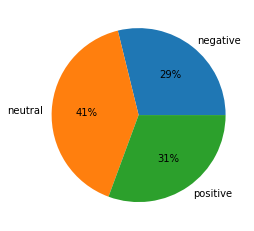

In [91]:
num_negative = df_neg.shape[0]
num_neutral = df_neutral.shape[0]
num_positive = df_positive.shape[0]
plt.pie([num_negative, num_neutral, num_positive], labels=['negative', 'neutral', 'positive'], autopct='%.0f%%')
None

# Just tokenization

In [97]:
def tokenize_doc(doc):
  return [casual_tokenize(text) for text in doc]

def normalization(tokenize_doc):
  return [[token.lower() for token in tokens] for tokens in tokenize_doc]

def remove_stopwords(tokenize_doc):
  stop_words = stopwords.words('english')
  return [[token for token in tokens if token not in stop_words] for tokens in tokenize_doc]

def make_bigrams(tokenize_doc):
  bigrams_phrases = Phrases(tokenize_doc)
  bigram = Phraser(bigrams_phrases)
  doc_bigram = [bigram[text] for text in tokenize_doc]
  return doc_bigram

FILTERS = [tokenize_doc, normalization, remove_stopwords, make_bigrams]

def preprocessing_doc(doc, filters=FILTERS):
  for f in filters:
    doc = f(doc)
  return doc

## One hot

In [106]:
def onehot_vectorize(doc):
  doc_seq = preprocessing_doc(doc)
  vocab = set()
  for token_seq in doc_seq:
    for word in token_seq:
      vocab.add(word)
  vocab = sorted(vocab)
  vocab_size = len(vocab)
  onehot_vectors = np.zeros((len(doc), vocab_size), int)
  for token_sequence in doc_seq:
    for i, word in enumerate(token_sequence):
      onehot_vectors[i, vocab.index(word)] = 1
  return onehot_vectors


### Split data on test and train parts 

In [113]:
df_onehot = onehot_vectorize(df['text'])
X_train_onehot, X_test_onehot, y_train, y_test = train_test_split(df_onehot, df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

### Naive Bayes

In [127]:
from sklearn.naive_bayes import MultinomialNB

MNB_onehot = MultinomialNB()
MNB_onehot.fit(X_train_onehot, y_train)
mnb_onehot_pred = MNB_onehot.predict(X_test_onehot)
print(f'accuracy: {accuracy_score(y_test, mnb_onehot_pred)}')

accuracy: 0.40903225806451615


### KNN

In [128]:
from sklearn.neighbors import KNeighborsClassifier

KNN_onehot = KNeighborsClassifier()
KNN_onehot.fit(X_train_onehot, y_train)
KNN_onehot_pred = KNN_onehot.predict(X_test_onehot)
print(f'accuracy: {accuracy_score(y_test, KNN_onehot_pred)}')

accuracy: 0.40903225806451615


### Random forest

In [129]:
from sklearn.ensemble import RandomForestClassifier

RF_onehot = RandomForestClassifier()
RF_onehot.fit(X_train_onehot, y_train)
RF_onehot_pred = RF_onehot.predict(X_test_onehot)
print(f'accuracy: {accuracy_score(y_test, RF_onehot_pred)}')

accuracy: 0.4129032258064516


## Word counts

In [132]:
from collections import Counter

bags_of_words = []
tokenize_doc = preprocessing_doc(df['text'])
for text in tokenize_doc:
  bags_of_words.append(Counter(text))
df_bows = pd.DataFrame.from_records(bags_of_words).fillna(0).astype(int)


### Split data

In [133]:
X_train_count, X_test_count, y_train, y_test = train_test_split(df_bows, df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

### Naive Byes

In [136]:
MNB_count = MultinomialNB()
MNB_count.fit(X_train_count, y_train)
MNB_count_pred = MNB_count.predict(X_test_count)
print(f'accuracy: {accuracy_score(y_test, MNB_count_pred)}')

accuracy: 0.8941935483870967


### KNN

In [135]:
KNN_count = KNeighborsClassifier()
KNN_count.fit(X_train_count, y_train)
KNN_count_pred = KNN_count.predict(X_test_count)
print(f'accuracy: {accuracy_score(y_test, KNN_count_pred)}')

accuracy: 0.8258064516129032


### Random forest

In [137]:
RF_count = RandomForestClassifier()
RF_count.fit(X_train_count, y_train)
RF_count_pred = RF_count.predict(X_test_count)
print(f'accuracy: {accuracy_score(y_test, RF_count_pred)}')

accuracy: 0.9032258064516129


## TF-IDF

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
X_train_preprocess = preprocess_documents(X_train)
X_train_preprocess[:5]

[['demonetis', 'note'],
 ['haha', 'thank', 'fansnim', 'happi'],
 ['review', 'lift', 'sanction', 'iran', 'tillerson'],
 ['great', 'trick', 'happi'],
 ['current',
  'stand',
  'outsid',
  'shard',
  'bag',
  'bottl',
  'came',
  'work',
  'tom',
  'todai',
  'happi']]